# Post-processing for jet in coflow
This script processes the Nalu data probes from the variable density jet in coflow calculation. For the values of number of axial, radial and azimuthal data probes, please see the input file. The probes are in the locations of Charonko and Presteridge (2017).

**Note:** There is variable reuse across datasets; to avoid pollution of namespace, run the cells immediately below the probe of interest.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
time_steps = 2
ax_points  = 1024
az_points  = 64
rd_points  = 1024

## Streamwise velocity axial variation

In [19]:
data = np.loadtxt('axial_avg_fa.dat', skiprows=1)
print(np.shape(data))

In [21]:
U = data[:,-3]
V = data[:,-2]
W = data[:,-1]
t = data[:,0]
x = data[:,2]
y = data[:,3]
z = data[:,4]

In [22]:
X = np.linspace(1.415,.415,ax_points)
X = (X-.415)/0.011
U = U/27.7

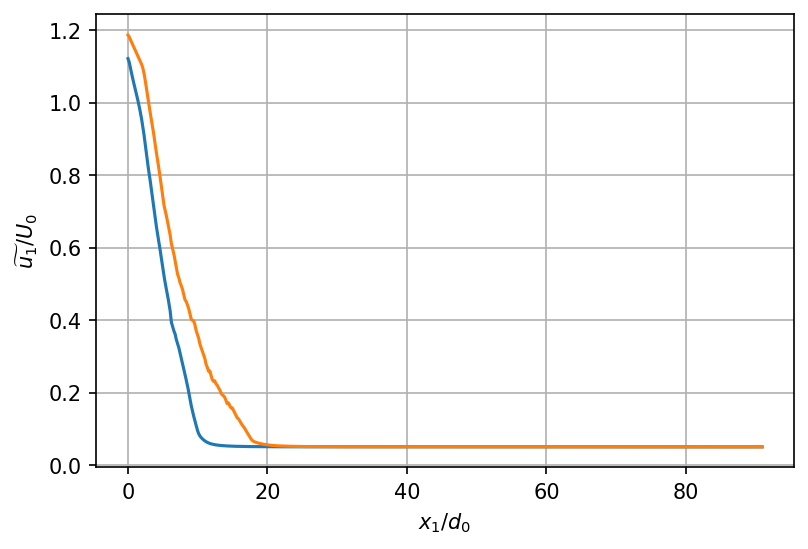

In [24]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(1, 1, 1)
for _ in range(time_steps):
    ax.plot(X,U[1024*_:1024*(_+1)])
ax.grid()
ax.set_xlabel('$x_1 / d_0$')
ax.set_ylabel('$\widetilde{u_1}/ {U_0}$')
plt.axis('tight')
plt.savefig('ax_v.png', dpi=300)

## Pipe velocity profile

In [17]:
data = np.loadtxt('pipe_full_ring.dat', skiprows=1)
print(np.shape(data))

(131072, 8)


In [18]:
U = data[:,-3]
V = data[:,-2]
W = data[:,-1]
t = data[:,0]
x = data[:,2]
y = data[:,3]
z = data[:,4]

In [20]:
# average over ring
U_last = U[int(len(U)/time_steps):]
U_avg = np.zeros(rd_points)
for i in range(rd_points):
    U_avg[i] = (np.mean(U_last[i*az_points:(i+1)*az_points-1]))/27.7
    
X = (np.linspace(0, 0.0055, rd_points))/0.011

In [31]:
print('The average velocity is', np.trapz(U_avg*27.7)/(len(U_avg)))

The average velocity is 29.80691565663752


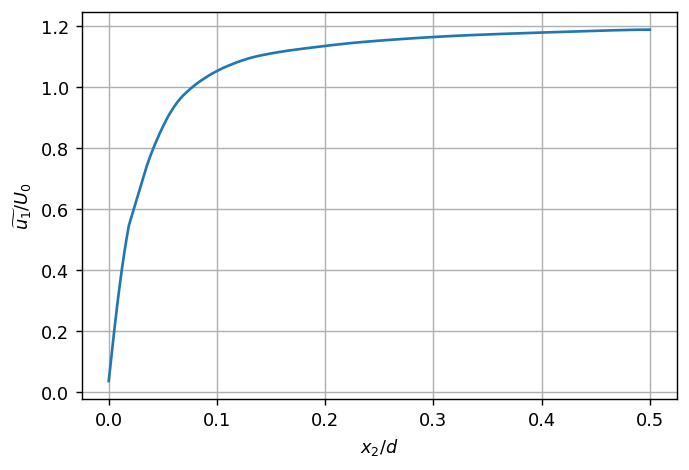

In [9]:
fig = plt.figure(dpi=128)
ax  = fig.add_subplot(1,1,1)
ax.plot(X, np.flip(U_avg))
ax.set_xlabel('$x_2/d$')
ax.set_ylabel('$\widetilde{u_1}/ {U_0}$')
plt.savefig('ring_avg.png',dpi=300)
plt.grid()

## Streamwise velocity axial variation

In [10]:
data1 = np.loadtxt('coflow_full_ring.dat', skiprows=1)
data2 = np.loadtxt('coflow_full_ring_2.dat', skiprows=1)
data3 = np.loadtxt('coflow_full_ring_3.dat', skiprows=1)
data = np.stack(((data1, data2, data3)))
print(np.shape(data))

(3, 131072, 8)


In [15]:
U_avg = np.zeros((3,ax_points))

for j in range(3):
    U = data[j,:,-3]
    U_last = U[int(len(U)/time_steps):]
    for i in range(ax_points):
        U_avg[j,i] = (np.mean(U_last[i*az_points:(i+1)*az_points-1]))/27.7   
        
X = (np.linspace(0, 0.265, rd_points))/0.011

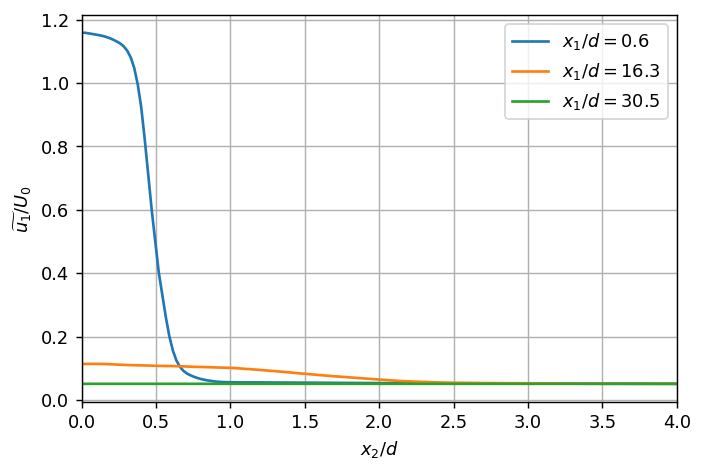

In [16]:
fig = plt.figure(dpi=128)
ax  = fig.add_subplot(1,1,1)
ax.plot(X,np.flip(U_avg[0,:]),label='$x_1/d = 0.6$')
ax.plot(X,np.flip(U_avg[1,:]),label='$x_1/d = 16.3$')
ax.plot(X,np.flip(U_avg[2,:]),label='$x_1/d = 30.5$')
ax.set_xlabel('$x_2/d$')
ax.set_ylabel('$\widetilde{u_1}/ {U_0}$')
ax.set_xlim([0,4])
ax.grid()
ax.legend()
plt.savefig('coflow_ring_avg.png',dpi=300)